<a href="https://colab.research.google.com/github/Zaidanebreak/Classification-Model-for-ATLAS-Higgs-Boson-Machine-Learning-Challenge-2014/blob/main/Addendum_2_for_BDT_on_HEP_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRI + DER  vs. PRI  vs. DER

In this Notebook we will apply the same procedures in the previous Notebooks but without applying any change to the dataset.

## Importing and Visualizing the Data

### Importing the Libraries 

In [1]:
import os    #provides functions for interacting with the operating system.
import numpy as np #provides a large set of numeric datatypes that you can use to construct arrays
import pandas as pd #work with dataframes 
import matplotlib.pyplot as plt #manipulate elements of a figure, such as creating a figure, creating a plotting area, plotting lines, adding plot labels, etc
from IPython.display import display, HTML 
import time 
np.random.seed(10) #to make the np.random yields the same result when used again. 

### Installing the Two Models 

In [2]:
!pip install xgboost --upgrade
pass
import xgboost #XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
import lightgbm #LightGBM is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage and it is a fast processing algorithm.
print("xgboost Version is: " + xgboost.__version__)
print("lightgbm Version is: " + lightgbm.__version__)

xgboost Version is: 1.4.2
lightgbm Version is: 2.2.3


### Connect your Google Colab with Google Drive 

In [3]:
!pip install PyDrive
import os 
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

# Here a link will appear you press on it, it will direct you to a page where you select the google account and copy the key and paste it in the required box.

### Upload the Dataset

In [4]:
download = drive.CreateFile({'id':'1hDw0S2idRsymTYDiDJkr0LYt-MOH_cFo'})  # here you juat take the ID part of the shared link file from google drive
download.GetContentFile("atlas-higgs-challenge-2014-v2.csv")  # Write the name of the file as in Google Drive

datapath=''
!ls -lrt
filename=os.path.join(datapath, "atlas-higgs-challenge-2014-v2.csv")   # the name of the file 
dfall = pd.read_csv(filename)   # Let python read the dataset
dfall = dfall.sample(frac=1).reset_index(drop=True) # to return a sample of the dataframe and reset the index if exists in the dataframe.
from datetime import datetime 
print("now:", datetime.now())
print("File loaded with", dfall.shape[0],"events ")   # dfall.shape gives the dimension of the dataframe and with [0] gives the first  dim. which is the number of rows. 

total 190972
drwxr-xr-x 1 root root      4096 Jul 16 13:20 sample_data
-rw-r--r-- 1 root root       720 Aug  5 11:29 adc.json
-rw-r--r-- 1 root root 195543089 Aug  5 11:59 atlas-higgs-challenge-2014-v2.csv
now: 2021-08-05 11:59:05.491404
File loaded with 818238 events 


### Defining the Smaller Dataframes 

In [5]:
target = dfall["Label"]
weights = dfall["Weight"]
dfall['Label_N'] = np.where(dfall['Label']=='s', 1,0)  
Target = dfall['Label_N']
DER_features = dfall[['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality']]
PRI_features = dfall[['PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']]
DER_and_PRI  = dfall[['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']]

### Heatmap For Signal Labeled Events 

Background features correlation matrix


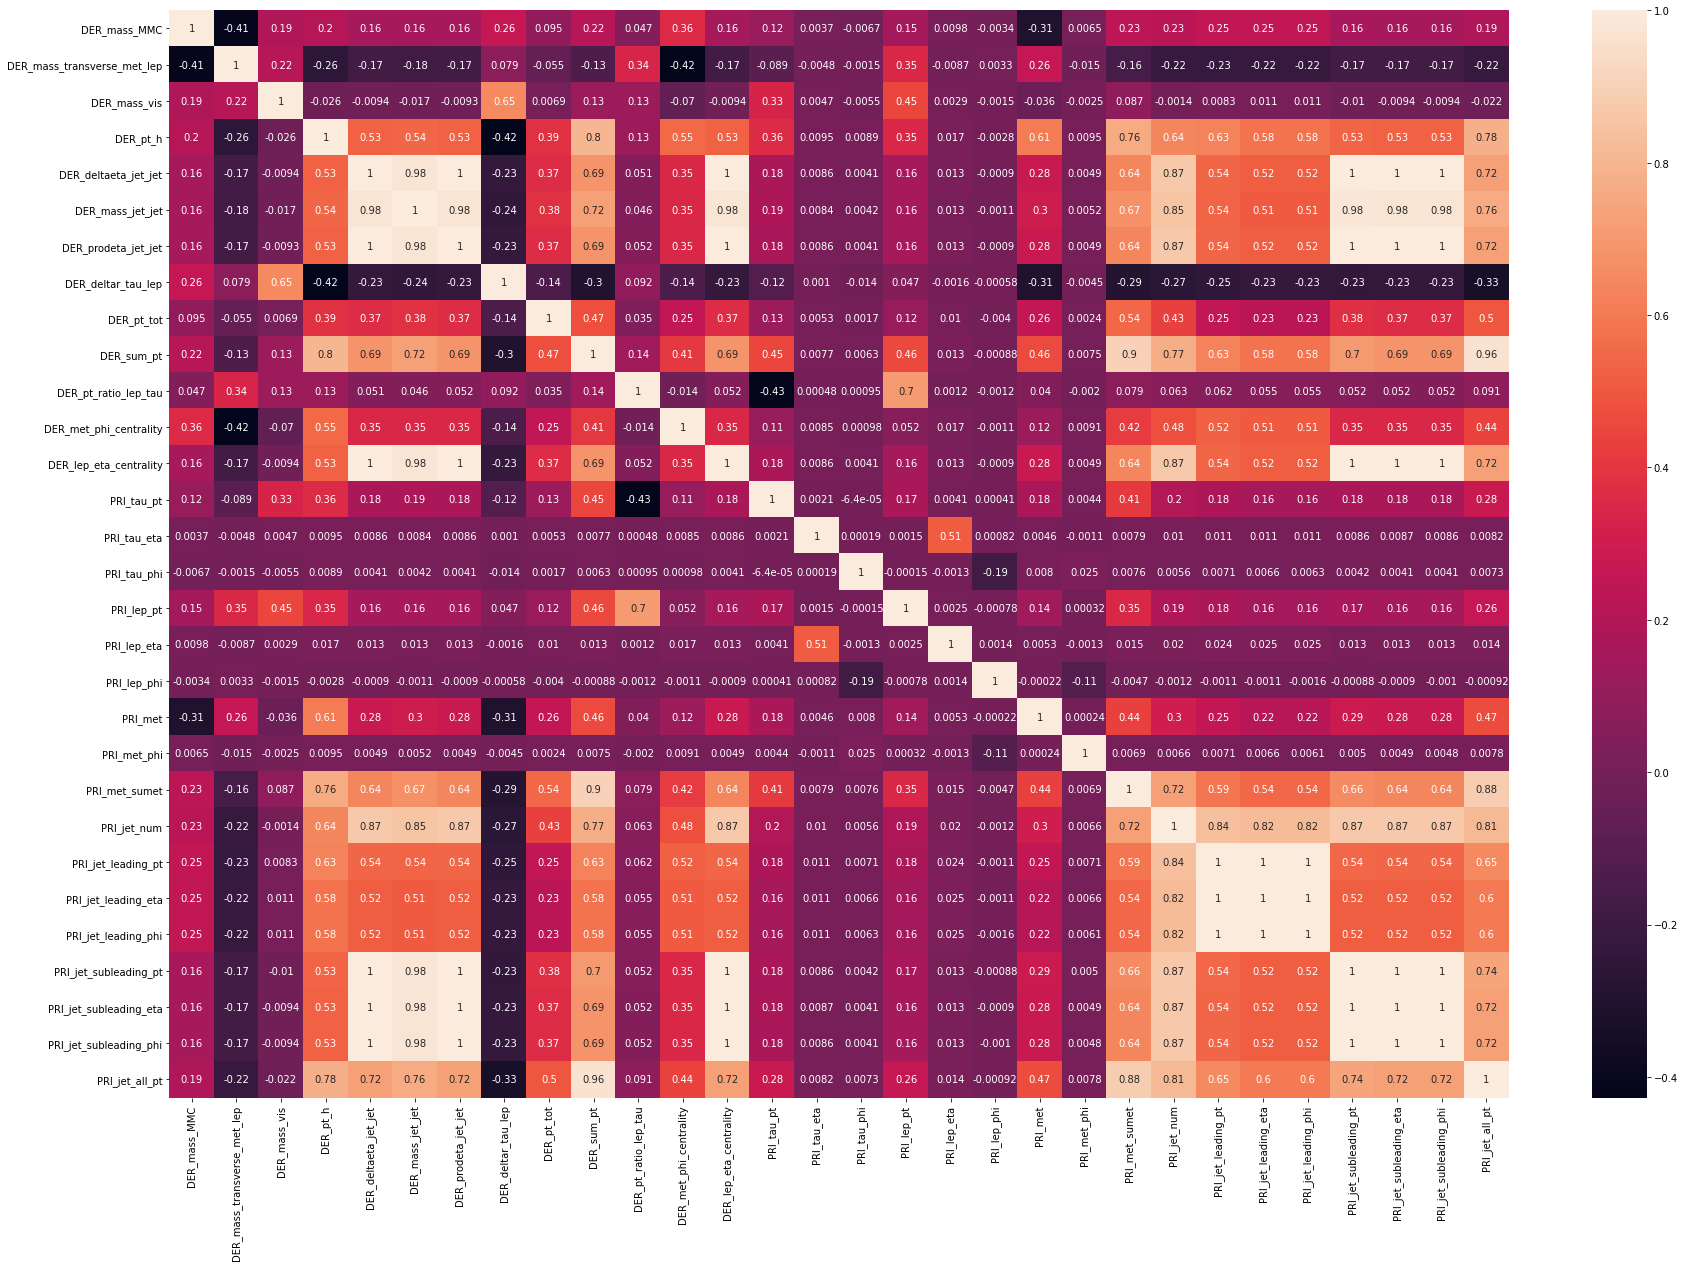

In [6]:
import seaborn as sn # seaborn for nice plot quicker
print ("Background features correlation matrix")
corrMatrix = DER_and_PRI[Target==0].corr()
plt.figure(figsize = (30,20))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Notice some features have correlation of $1$ between them which is impossible, that's due to extreme value, only the main diagonal should be $1$ 

### Heatmap for Background Labeled Features 

Signal feature correlation matrix


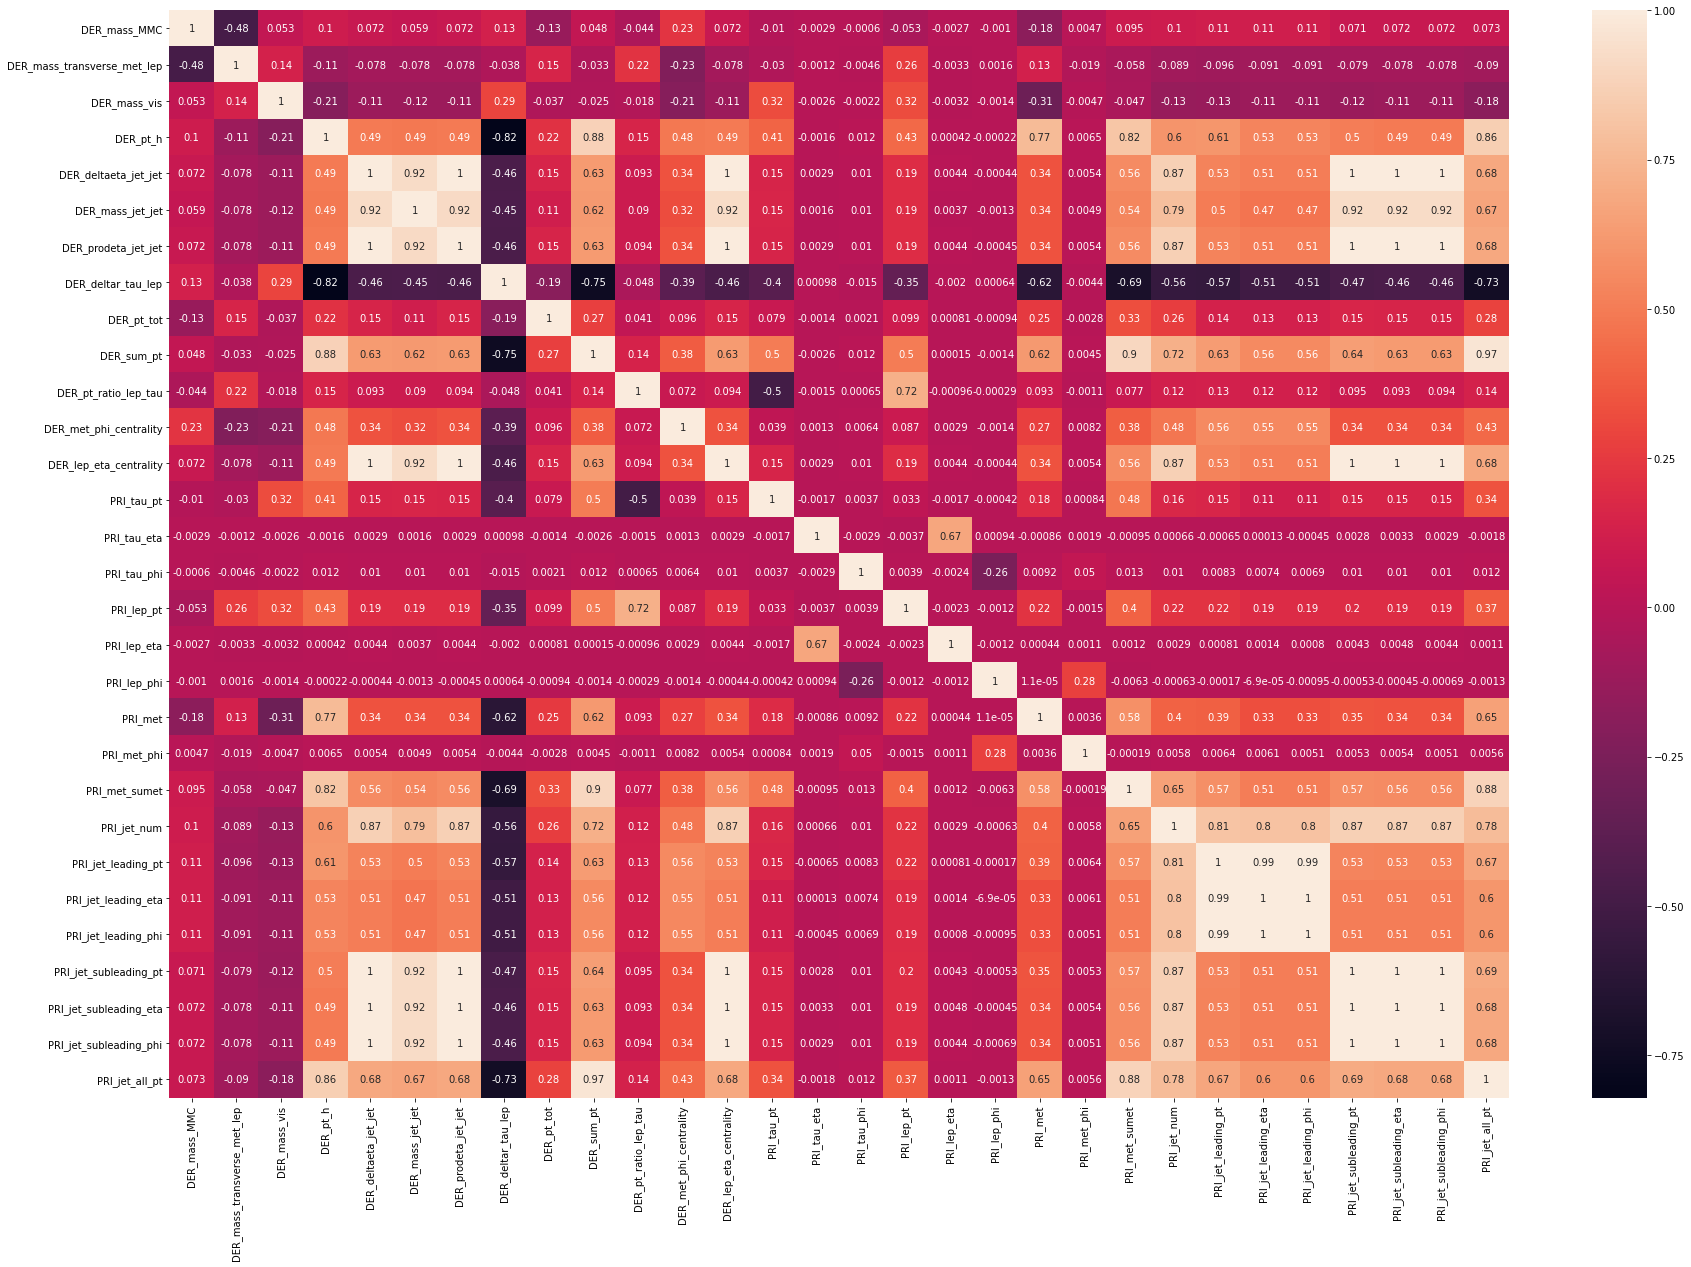

In [7]:
print ("Signal feature correlation matrix")
corrMatrix = DER_and_PRI[Target==1].corr()
plt.figure(figsize = (30,20))
sn.heatmap(corrMatrix, annot=True)
plt.show()

## DER + PRI Features

### Split the Data 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.61106915102 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(DER_and_PRI, Target, weights, train_size=train_size, random_state = 31415)  # add random state instead of random seed
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

### Rescaling 

In [9]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

for i in range(len(class_weights_train)):
    #training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] 
    #test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1/(1-train_size) 

### Defining the AMS Function for Significance 

In [10]:
from math import sqrt
from math import log
def amsasimov(s,b): # asimov significance arXiv:1007.1727 eq. 97  + footnote 
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

### Applying the XGB Model 

In [11]:
#np.random.seed(31415) # set the random seed  useful?  try checking without 

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0
xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',random_state = 31415)
# HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters
#xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,max_depth=10,n_estimators=100) 



starting_time = time.time()

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values) # note that XGB 1.3.X requires positive weight

        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb_DER_and_PRI = xgb.predict_proba(X_test)[:,1]
y_pred_xgb_DER_and_PRI = y_pred_xgb_DER_and_PRI.ravel()
y_pred_train_xgb_DER_and_PRI = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb_DER_and_PRI = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_DER_and_PRI,sample_weight=weights_test)
print("auc test:",auc_test_xgb_DER_and_PRI)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_DER_and_PRI,))
int_pred_test_sig_xgb_DER_and_PRI = [weights_test[(y_test ==1) & (y_pred_xgb_DER_and_PRI > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb_DER_and_PRI = [weights_test[(y_test ==0) & (y_pred_xgb_DER_and_PRI > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb_DER_and_PRI = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb_DER_and_PRI,int_pred_test_bkg_xgb_DER_and_PRI)]
significance_xgb_DER_and_PRI = max(vamsasimov_xgb_DER_and_PRI)
V = significance_xgb_DER_and_PRI
print("Z:",V)
# To save model
#xgb.save_model("XGBoost.model")

Training time: 13.932520627975464
auc test: 0.9349055376281966
auc train: 0.91125383077061
Z: 3.6940199753879455


### Learning Curve 

In [12]:
#In principle could, use learning_curve in sklearn
#However : it does not handle weights, it does not allow to control testing dataset size
#from sklearn.model_selection import learning_curve
#train_sizes,train_scores,test_scores=learning_curve(
#     XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',n_estimators=10),
#     X_train,y_train,
#     train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1],                  
#     scoring='roc_auc',cv=5)


train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1]
ntrains=[]
test_aucs=[]
train_aucs=[]
times=[]
z = []

for train_size in train_sizes:
  ntrain=int(len(X_train)*train_size)
  print("training with ",ntrain," events")
  ntrains+=[ntrain]
  starting_time = time.time()

  # train using the first ntrain event of the training dataset
  xgb.fit(X_train[:ntrain,], y_train[:ntrain], sample_weight=weights_train[:ntrain])
  training_time = time.time( ) - starting_time
  times+=[training_time]

  # score on test dataset (always the same)
  y_pred_xgb=xgb.predict_proba(X_test)[:,1]
  auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test)
  test_aucs+=[auc_test_xgb]

  # score on the train dataset 
  y_train_xgb=xgb.predict_proba(X_train[:ntrain])[:,1]
  auc_train_xgb = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_xgb,sample_weight=weights_train[:ntrain])
  train_aucs+=[auc_train_xgb]
  
  int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
  significance_xgb = max(vamsasimov_xgb)
  Z = significance_xgb
  z+=[Z]

dflearning_together=pd.DataFrame({"Ntraining":ntrains,
                         "test_auc":test_aucs,
                         "train_auc":train_aucs,
                         "time":times,
                         "Significance": z})
display(dflearning_together)

training with  4999  events
training with  24999  events
training with  49999  events
training with  99999  events
training with  249999  events
training with  374999  events
training with  499999  events


,Ntraining,test_auc,train_auc,time,Significance
0,4999,0.909422,0.999814,1.028867,2.860470
1,24999,0.920518,0.992977,2.023252,3.146311
2,49999,0.925350,0.981857,2.759185,3.295600
3,99999,0.929018,0.969457,4.070883,3.402464
4,249999,0.932789,0.954205,7.915235,3.603659
5,374999,0.934075,0.949378,10.976152,3.655763
6,499999,0.934906,0.947235,13.807859,3.694020


### Applying LightGBM Model 

In [13]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
#gbm = lgb.LGBMClassifier()
gbm = lgb.LGBMClassifier(random_state = 31415)
# gbm = lgb.LGBMClassifier(max_depth=12) # HPO, check on the web https://lightgbm.readthedocs.io/ for other parameters


starting_time = time.time( )

gbm.fit(X_train, y_train.values,sample_weight=weights_train.values)
#gbm.fit(X_train, y_train.values) #ma


training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1].ravel()
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm, sample_weight = weights_test)
print("auc test:",auc_test_gbm)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))

int_pred_test_sig_gbm = [weights_test[(y_test ==1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test ==0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_gbm = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_gbm,int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
C = significance_gbm
print("Z:",C)


Training time: 12.813933849334717
auc test: 0.9346672400335796
auc train: 0.9006914828567159
Z: 3.646805421163873


## DER Features 

### Splitting The Data 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.61106915102 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(DER_features, Target, weights, train_size=train_size, random_state = 31415)  # add random state instead of random seed
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

### Rescaling 

In [15]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

for i in range(len(class_weights_train)):
    #training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] 
    #test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1/(1-train_size) 

### Applying the XGB Model 

In [16]:
#np.random.seed(31415) # set the random seed  useful?  try checking without 

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0
xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',random_state = 31415)
# HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters
#xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,max_depth=10,n_estimators=100) 



starting_time = time.time()

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values) # note that XGB 1.3.X requires positive weight

        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb_DER = xgb.predict_proba(X_test)[:,1]
y_pred_xgb_DER = y_pred_xgb_DER.ravel()
y_pred_train_xgb_DER = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb_DER = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_DER,sample_weight=weights_test)
print("auc test:",auc_test_xgb_DER)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_DER,))
int_pred_test_sig_xgb_DER = [weights_test[(y_test ==1) & (y_pred_xgb_DER > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb_DER = [weights_test[(y_test ==0) & (y_pred_xgb_DER > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb_DER = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb_DER,int_pred_test_bkg_xgb_DER)]
significance_xgb_DER = max(vamsasimov_xgb_DER)
U = significance_xgb_DER
print("Z:",U)
# To save model
#xgb.save_model("XGBoost.model")

Training time: 8.036699295043945
auc test: 0.9308572920623481
auc train: 0.9049951960040007
Z: 3.493873064802636


### Learning Curve 

In [17]:
#In principle could, use learning_curve in sklearn
#However : it does not handle weights, it does not allow to control testing dataset size
#from sklearn.model_selection import learning_curve
#train_sizes,train_scores,test_scores=learning_curve(
#     XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',n_estimators=10),
#     X_train,y_train,
#     train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1],                  
#     scoring='roc_auc',cv=5)


train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1]
ntrains=[]
test_aucs=[]
train_aucs=[]
times=[]
z = []

for train_size in train_sizes:
  ntrain=int(len(X_train)*train_size)
  print("training with ",ntrain," events")
  ntrains+=[ntrain]
  starting_time = time.time()

  # train using the first ntrain event of the training dataset
  xgb.fit(X_train[:ntrain,], y_train[:ntrain], sample_weight=weights_train[:ntrain])
  training_time = time.time( ) - starting_time
  times+=[training_time]

  # score on test dataset (always the same)
  y_pred_xgb=xgb.predict_proba(X_test)[:,1]
  auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test)
  test_aucs+=[auc_test_xgb]

  # score on the train dataset 
  y_train_xgb=xgb.predict_proba(X_train[:ntrain])[:,1]
  auc_train_xgb = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_xgb,sample_weight=weights_train[:ntrain])
  train_aucs+=[auc_train_xgb]
  
  int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
  significance_xgb = max(vamsasimov_xgb)
  Z = significance_xgb
  z+=[Z]

dflearning_DER_alone=pd.DataFrame({"Ntraining":ntrains,
                         "test_auc":test_aucs,
                         "train_auc":train_aucs,
                         "time":times,
                         "Significance": z})
display(dflearning_DER_alone)

training with  4999  events
training with  24999  events
training with  49999  events
training with  99999  events
training with  249999  events
training with  374999  events
training with  499999  events


,Ntraining,test_auc,train_auc,time,Significance
0,4999,0.905041,0.998878,0.421791,2.715177
1,24999,0.918757,0.985168,0.921872,3.094986
2,49999,0.922616,0.972558,1.340147,3.206388
3,99999,0.926050,0.960241,2.110437,3.348563
4,249999,0.929097,0.947221,4.263514,3.480719
5,374999,0.930387,0.943207,6.147809,3.539837
6,499999,0.930857,0.941517,8.003448,3.493873


### Applying LightGBM Model

In [18]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
#gbm = lgb.LGBMClassifier()
gbm = lgb.LGBMClassifier(random_state = 31415)
# gbm = lgb.LGBMClassifier(max_depth=12) # HPO, check on the web https://lightgbm.readthedocs.io/ for other parameters


starting_time = time.time( )

gbm.fit(X_train, y_train.values,sample_weight=weights_train.values)
#gbm.fit(X_train, y_train.values) #ma


training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1].ravel()
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm, sample_weight = weights_test)
print("auc test:",auc_test_gbm)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))

int_pred_test_sig_gbm = [weights_test[(y_test ==1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test ==0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_gbm = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_gbm,int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
Q = significance_gbm
print("Z:",Q)


Training time: 6.8646934032440186
auc test: 0.9303564610266208
auc train: 0.8954581606611715
Z: 3.4429160561206142


## PRI Features

### Data Splitting 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.61106915102 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(PRI_features, Target, weights, train_size=train_size, random_state = 31415)  # add random state instead of random seed
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

### Rescaling 

In [20]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

for i in range(len(class_weights_train)):
    #training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] 
    #test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1/(1-train_size) 

### Applying XGB Model

In [21]:
#np.random.seed(31415) # set the random seed  useful?  try checking without 

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0
xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',random_state = 31415)
# HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters
#xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,max_depth=10,n_estimators=100) 



starting_time = time.time()

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values) # note that XGB 1.3.X requires positive weight

        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb_PRI = xgb.predict_proba(X_test)[:,1]
y_pred_xgb_PRI = y_pred_xgb_PRI.ravel()
y_pred_train_xgb_PRI = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb_PRI = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_PRI,sample_weight=weights_test)
print("auc test:",auc_test_xgb_PRI)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_PRI,))
int_pred_test_sig_xgb_PRI = [weights_test[(y_test ==1) & (y_pred_xgb_PRI > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb_PRI = [weights_test[(y_test ==0) & (y_pred_xgb_PRI > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb_PRI = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb_PRI,int_pred_test_bkg_xgb_PRI)]
significance_xgb_PRI = max(vamsasimov_xgb_PRI)
P = significance_xgb_PRI
print("Z:",P)
# To save model
#xgb.save_model("XGBoost.model")

Training time: 10.0149986743927
auc test: 0.9106159625187557
auc train: 0.8595608585003502
Z: 2.7373231878919815


### Learning Curve 

In [22]:
#In principle could, use learning_curve in sklearn
#However : it does not handle weights, it does not allow to control testing dataset size
#from sklearn.model_selection import learning_curve
#train_sizes,train_scores,test_scores=learning_curve(
#     XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',n_estimators=10),
#     X_train,y_train,
#     train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1],                  
#     scoring='roc_auc',cv=5)


train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1]
ntrains=[]
test_aucs=[]
train_aucs=[]
times=[]
z = []

for train_size in train_sizes:
  ntrain=int(len(X_train)*train_size)
  print("training with ",ntrain," events")
  ntrains+=[ntrain]
  starting_time = time.time()

  # train using the first ntrain event of the training dataset
  xgb.fit(X_train[:ntrain,], y_train[:ntrain], sample_weight=weights_train[:ntrain])
  training_time = time.time( ) - starting_time
  times+=[training_time]

  # score on test dataset (always the same)
  y_pred_xgb=xgb.predict_proba(X_test)[:,1]
  auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test)
  test_aucs+=[auc_test_xgb]

  # score on the train dataset 
  y_train_xgb=xgb.predict_proba(X_train[:ntrain])[:,1]
  auc_train_xgb = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_xgb,sample_weight=weights_train[:ntrain])
  train_aucs+=[auc_train_xgb]
  
  int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
  significance_xgb = max(vamsasimov_xgb)
  Z = significance_xgb
  z+=[Z]

dflearning_PRI_alone=pd.DataFrame({"Ntraining":ntrains,
                         "test_auc":test_aucs,
                         "train_auc":train_aucs,
                         "time":times,
                         "Significance": z})
display(dflearning_PRI_alone)

training with  4999  events
training with  24999  events
training with  49999  events
training with  99999  events
training with  249999  events
training with  374999  events
training with  499999  events


,Ntraining,test_auc,train_auc,time,Significance
0,4999,0.855088,0.998911,0.700872,1.937946
1,24999,0.884727,0.982818,1.308596,2.273249
2,49999,0.893370,0.965781,1.871795,2.387067
3,99999,0.901433,0.949770,2.738849,2.543502
4,249999,0.906731,0.932617,5.412491,2.663618
5,374999,0.909266,0.927894,7.733812,2.727292
6,499999,0.910616,0.925677,10.030116,2.737323


### Applying LightGBM Model

In [23]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
#gbm = lgb.LGBMClassifier()
gbm = lgb.LGBMClassifier(random_state = 31415)
# gbm = lgb.LGBMClassifier(max_depth=12) # HPO, check on the web https://lightgbm.readthedocs.io/ for other parameters


starting_time = time.time( )

gbm.fit(X_train, y_train.values,sample_weight=weights_train.values)
#gbm.fit(X_train, y_train.values) #ma


training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1].ravel()
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm, sample_weight = weights_test)
print("auc test:",auc_test_gbm)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))

int_pred_test_sig_gbm = [weights_test[(y_test ==1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test ==0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_gbm = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_gbm,int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
S = significance_gbm
print("Z:",S)


Training time: 7.898534774780273
auc test: 0.8841007416016079
auc train: 0.8160853645707853
Z: 2.3046806356677387


## Compare Significance Values

In [24]:
print("Significance Values for each case and respective model, Here no changes applied to Dataframe")
from tabulate import tabulate
table = [["DataFrame", 'Model', 'Significance'], ['DER + PRI', 'XGB', V], ['DER + PRI', 'LightGBM', C], ['DER', 'XGB', U], ['DER', 'LightGBM', Q], ['PRI', 'XGB', P], ['PRI', 'LightGBM', S]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Significance Values for each case and respective model, Here no changes applied to Dataframe
╒═════════════╤══════════╤════════════════╕
│ DataFrame   │ Model    │   Significance │
╞═════════════╪══════════╪════════════════╡
│ DER + PRI   │ XGB      │        3.69402 │
├─────────────┼──────────┼────────────────┤
│ DER + PRI   │ LightGBM │        3.64681 │
├─────────────┼──────────┼────────────────┤
│ DER         │ XGB      │        3.49387 │
├─────────────┼──────────┼────────────────┤
│ DER         │ LightGBM │        3.44292 │
├─────────────┼──────────┼────────────────┤
│ PRI         │ XGB      │        2.73732 │
├─────────────┼──────────┼────────────────┤
│ PRI         │ LightGBM │        2.30468 │
╘═════════════╧══════════╧════════════════╛
